# CIFAR-10

> In this module, we tackle a larger classification challenge with the CIFAR-10 dataset


Adapted from

- [https://www.youtube.com/watch?v=PXiD7ZjOKhA&t=2s](https://www.youtube.com/watch?v=PXiD7ZjOKhA&t=2s)

In [1]:
#| default_exp cifar10

In [2]:
import math

import fastcore.all as fc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import wandb
from functools import partial
from diffusers import UNet2DModel
from torch import tensor
from torch.optim import lr_scheduler
from tqdm import tqdm

from slowai.cos_revisited import DDPM
from slowai.learner import (
    Callback,
    DataLoaders,
    DeviceCB,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    after,
    def_device,
    only,
    tensorize_images,
)
from slowai.sgd import BatchSchedulerCB, RecorderCB
from slowai.utils import clean_mem, get_grid, glomf, show_image, show_images

In [3]:
RecorderCB??

Init signature: RecorderCB(**d)
Source:        
class RecorderCB(Callback):
    """Record internal state values at each batch."""

    def __init__(self, **d):
        self.d = d
        self.learn = None

    def before_fit(self, learn):
        self.learn = learn
        self.recs = {k: [] for k in self.d}
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if not learn.training:
            return
        for k, v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self, **kwargs):
        n = len(self.recs)
        if "figsize" not in kwargs:
            K = 3
            kwargs["figsize"] = (K * n, K)
        fig, axes = plt.subplots(1, n, **kwargs)
        if n > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        for ax, (k, v) in zip(axes, self.recs.items()):
            ax.plot(v, label=k)
            ax.legend()
        fig.tight_layout()
File:           ~/Desktop/SlowAI/nbs/slowai/sgd.p

Some notes about CIFAR-10:

- CIFAR-10 is the smallest dataset  still used in the deep learning literature
- 94% accuracy is a baseline
- Jeremy does not like it, probably because things are two blurry for a human

In [4]:
def get_dls(bs=32):
    return tensorize_images(
        DataLoaders.from_hf("cifar10", bs=bs), feature="img", normalize=False
    ).listify()

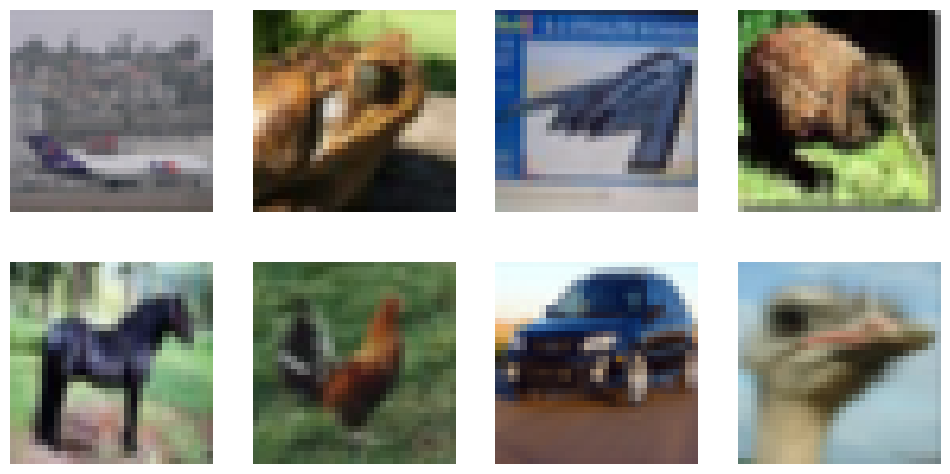

In [5]:
dls = get_dls()
imgs, _ = dls.peek()
show_images(imgs[:8, ...])

## Experiment Tracking with Weights and Biases

We want to practice keeping track of the experimental results. Weights and Biases is a great to do so.

In [6]:
MetricsCB??

Init signature: MetricsCB(*ms, **metrics)
Source:        
class MetricsCB(Callback):
    """Update and print metrics"""

    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics["loss"] = self.loss = torchmetrics.aggregation.MeanMetric()

    def _log(self, d, learn):
        print(d)

    def before_fit(self, learn):
        learn.metrics = self

    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f"{v.compute():.3f}" for k, v in self.all_metrics.items()}
        log["epoch"] = learn.epoch
        log["train"] = "train" if learn.model.training else "eval"
        self._log(log, learn)

    def after_batch(self, learn):
        x, y = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(learn.preds.cpu(), y)
        self.loss.up

In [7]:
# |export
class WandBDDPM(MetricsCB, order=1000):
    def __init__(self, config, *ms, project=None, sample_f, **metrics):
        if project is None:
            raise ValueError("Please specify a wandb project")
        fc.store_attr()
        super().__init__(*ms, **metrics)

    def before_fit(self, learn):
        wandb.init(project=self.project, config=self.config)

    def after_fit(self, learn):
        wandb.finish()

    def _log(self, d, learn):
        if learn.model.training:
            wandb.log({"train_" + m: float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({"val_" + m: float(d[m]) for m in self.all_metrics})
            wandb.log({"samples": self.sample_figure(learn)})
        print(d)

    @torch.no_grad()
    def sample_figure(self, learn):
        samples = self.sample_f()
        bs, *chw = samples.shape
        K = math.ceil(math.sqrt(bs))
        fig, axes = plt.subplots(K, K, figsize=(2 * K, 2 * K))
        for im, ax in zip(samples, axes.flat):
            show_image(im.clamp(0.0, 1.0), ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({"loss": learn.loss})

As a motivating example, we'll train a CIFAR-10 U-Net with more or fewer parameters.

In [9]:
# |export
def cifar10_unet(small: bool):
    if small:
        return UNet2DModel(
            in_channels=3,
            out_channels=3,
            block_out_channels=(32, 64, 128, 256),
            norm_num_groups=8,
        )
    else:
        return UNet2DModel(in_channels=3, out_channels=3)

In [10]:
def get_model_sizes():
    for small in [True, False]:
        model = cifar10_unet(small=small)
        print(f"{sum(p.numel() for p in model.parameters()):,}")


get_model_sizes()

15,891,907
274,056,163


In [11]:
# |export
def train(
    model,
    lr=1e-3,
    n_epochs=2,
    bs=256,
    opt_func=partial(torch.optim.Adam, eps=1e-5),
    extra_cbs=[],
    ddpm=DDPM(),
):
    dls = get_dls(bs)

    def sample():
        return ddpm.sample(model, sz=(9, 3, 32, 32), n_steps=100)

    wb = WandBDDPM(
        config={"lr": lr, "epochs": n_epochs, "bs": bs},
        project="cifar10-ddpm",
        sample_f=sample,
    )
    T_max = len(dls["train"]) * n_epochs

    def get_lr(recorder):
        return recorder.learn.opt.param_groups[0]["lr"]

    recorder = RecorderCB(lr=get_lr)
    recorder.order = 999
    cbs = [
        ddpm,
        wb,
        TrainCB(),
        MetricsCB(),
        DeviceCB(),
        ProgressCB(plot=True),
        BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max),
        recorder,
        *extra_cbs,
    ]
    Learner(
        model,
        dls,
        F.mse_loss,
        lr=lr,
        cbs=cbs,
        opt_func=opt_func,
    ).fit(n_epochs)
    recorder.plot()
    return ddpm

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jfisher40. Use `wandb login --relogin` to force relogin


loss,epoch,train
0.260,0,train
0.071,0,eval
0.063,1,train
0.059,1,eval


{'loss': '0.260', 'epoch': 0, 'train': 'train'}


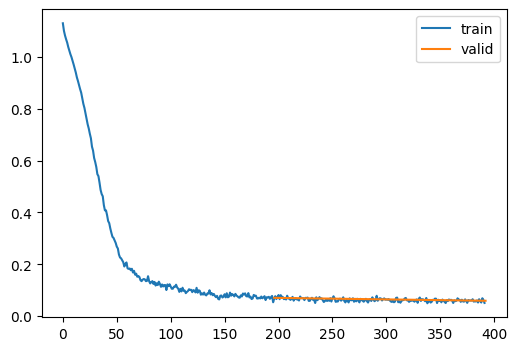

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 64.64time step/s]


{'loss': '0.071', 'epoch': 0, 'train': 'eval'}
{'loss': '0.063', 'epoch': 1, 'train': 'train'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 66.82time step/s]


{'loss': '0.059', 'epoch': 1, 'train': 'eval'}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▇▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁
val_loss,█▁
loss,0.10664
train_loss,0.063
val_loss,0.059


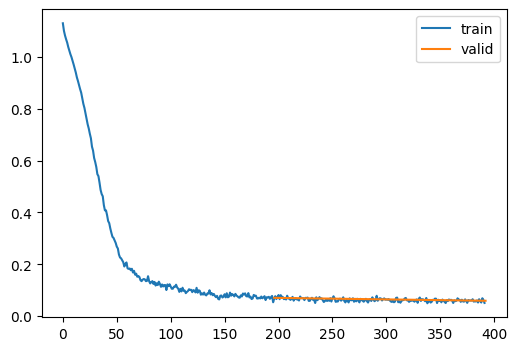

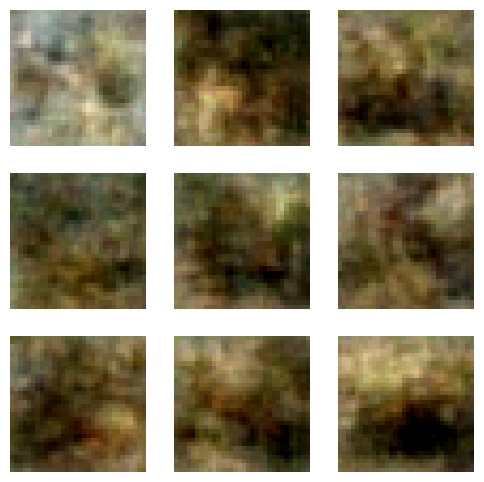

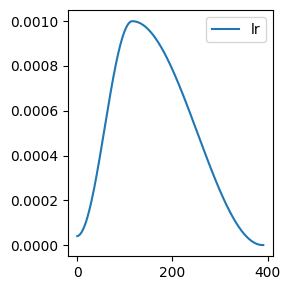

In [12]:
train(cifar10_unet(small=True))

loss,epoch,train
0.570,0,train
1.000,0,eval
1.000,1,train
1.000,1,eval


{'loss': '0.570', 'epoch': 0, 'train': 'train'}


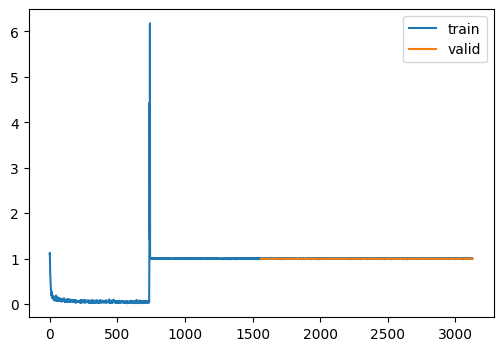

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 29.56time step/s]


{'loss': '1.000', 'epoch': 0, 'train': 'eval'}
{'loss': '1.000', 'epoch': 1, 'train': 'train'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 30.27time step/s]


{'loss': '1.000', 'epoch': 1, 'train': 'eval'}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,▁▂▁▁▁▁▁▁████████████████████████████████
train_loss,▁█
val_loss,▁▁
loss,0.99901
train_loss,1.0
val_loss,1.0


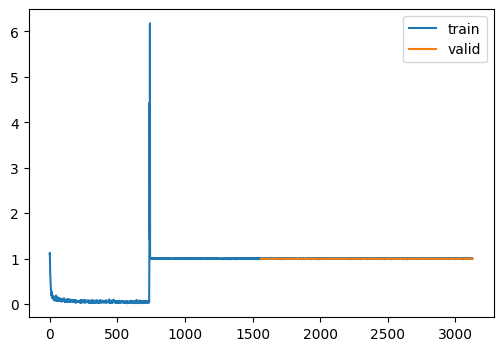

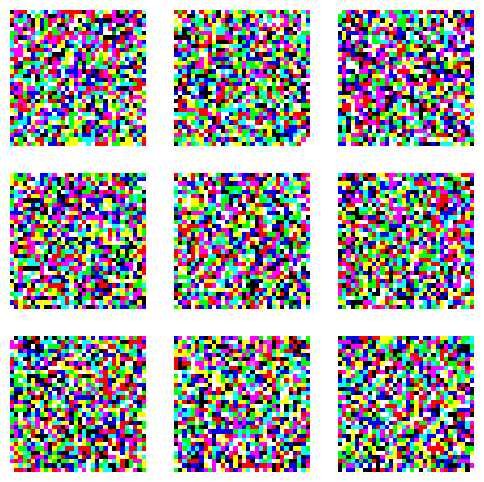

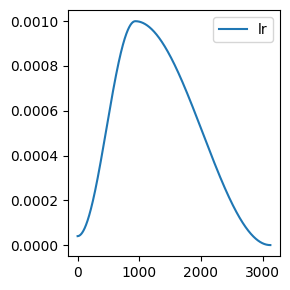

In [13]:
train(cifar10_unet(small=False), bs=32)

We seem to have convergence issues.

Some things to try:

- Reduce LR
- Experiment with initialization

In [14]:
#| hide
import nbdev

nbdev.nbdev_export()